In [1]:
!pip install torchtuples

In [2]:
!pip install pycox

In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import math
import pickle
import copy
import seaborn as sns
from numpy import sqrt 

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False 

pd.options.display.float_format = '{:.5f}'.format

import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import random
from keras.callbacks import EarlyStopping

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/Final_Data.xlsx')

# Deepsurv

In [6]:
def deepsurv(dataset, start_col, end_col): 
    
    df_preprocessed = dataset.copy(deep=True)
    
    df_train, df_test = train_test_split(df_preprocessed, test_size=0.3, random_state=30)
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=30)
    
    cols_leave = list(df_preprocessed.loc[:, start_col:end_col].columns)
    leave = [(col, None) for col in cols_leave]
    x_mapper = DataFrameMapper(leave)
    
    x_train = x_mapper.fit_transform(df_train).astype('float32')
    x_val = x_mapper.transform(df_val).astype('float32')
    x_test = x_mapper.transform(df_test).astype('float32')
    
    get_target = lambda df: (df_preprocessed['y_cum_time'].values, df_preprocessed['event'].values)
    y_train = (df_preprocessed.loc[df_train.index,'y_cum_time'].values, df_preprocessed.loc[df_train.index,'event'].values)
    y_val = (df_preprocessed.loc[df_val.index,'y_cum_time'].values, df_preprocessed.loc[df_val.index,'event'].values)
    durations_test, events_test = (df_preprocessed.loc[df_test.index,'y_cum_time'].values, df_preprocessed.loc[df_test.index,'event'].values)
    val = x_val, y_val
    
    # Neural Net
    in_features = x_train.shape[1]
    num_nodes = [64, 64, 64, 64]
    out_features = 1
    batch_norm = True
    dropout = 0.1
    output_bias = False

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias)
    
    # Training The Model 
    model = CoxPH(net, tt.optim.Adam)
    batch_size = 128
    model.optimizer.set_lr(0.01)

    epochs = 1000
    callbacks = [tt.callbacks.EarlyStopping(patience=10)]
    verbose = True
    
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
    
    # Prediction 
    _ = model.compute_baseline_hazards()
    surv = model.predict_surv_df(x_test)
    
    # Evaluation 
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    print("concordance_td: ",ev.concordance_td())
    print("integrated_brier_score:", ev.integrated_brier_score(time_grid))
    print("integrated_nbll:", ev.integrated_nbll(time_grid))

    return surv


def predicted_median(result_surv):
    # Predictied median time
    pred_df = pd.DataFrame()
    pred_df['lamp_idx'] = list(result_surv.columns)
    pred_df['predicted_time'] = 0

    for col in list(result_surv.columns):
        val = max(result_surv[col][result_surv[col]>=0.5].index)
        pred_df.loc[col, 'predicted_time'] = val
        
    return pred_df

### Experiment 1: Original Dataset

In [7]:
deepsurv(df,"1-수소공급량","강도")

0:	[0s / 0s],		train_loss: 3.6405,	val_loss: 13.7257
1:	[0s / 0s],		train_loss: 3.4210,	val_loss: 12.2704
2:	[0s / 0s],		train_loss: 3.2192,	val_loss: 14.7671
3:	[0s / 0s],		train_loss: 3.2860,	val_loss: 15.6133
4:	[0s / 0s],		train_loss: 3.3379,	val_loss: 15.6866
5:	[0s / 0s],		train_loss: 3.3092,	val_loss: 15.9575
6:	[0s / 0s],		train_loss: 3.2633,	val_loss: 19.5450
7:	[0s / 0s],		train_loss: 3.3590,	val_loss: 24.8035
8:	[0s / 0s],		train_loss: 3.1029,	val_loss: 27.9504
9:	[0s / 0s],		train_loss: 3.2087,	val_loss: 29.7410
10:	[0s / 0s],		train_loss: 3.0578,	val_loss: 32.8798
11:	[0s / 0s],		train_loss: 3.0111,	val_loss: 33.2609
concordance_td:  0.4628136200716846
integrated_brier_score: 0.23232837128418288
integrated_nbll: 1.0427389428539033


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99637,0.99469,0.99614,0.99543,0.99609,0.99681,0.99543,0.99536,0.99469,0.99679,0.99517,0.99311,0.97430,0.99473,0.99451,0.99527,0.99480,0.97319,0.99606,0.99465,0.99510,0.99545,0.99572,0.99599,0.99607,0.99767,0.99581,0.97518,0.99612,0.99550,0.99418,0.99511,0.99777,0.99598,0.99470,0.98112,0.99468,0.99420,0.99406,0.99528,...,0.99542,0.99450,0.99467,0.99649,0.99494,0.99448,0.99523,0.99543,0.99495,0.99683,0.99608,0.99449,0.99732,0.99472,0.99458,0.99500,0.99497,0.99629,0.97484,0.99778,0.99457,0.99603,0.99522,0.99534,0.99565,0.99566,0.99668,0.99496,0.99102,0.99500,0.99467,0.99586,0.97645,0.99624,0.99576,0.99423,0.99608,0.99775,0.99546,0.99347
44.08000,0.99637,0.99469,0.99614,0.99543,0.99609,0.99681,0.99543,0.99536,0.99469,0.99679,0.99517,0.99311,0.97430,0.99473,0.99451,0.99527,0.99480,0.97319,0.99606,0.99465,0.99510,0.99545,0.99572,0.99599,0.99607,0.99767,0.99581,0.97518,0.99612,0.99550,0.99418,0.99511,0.99777,0.99598,0.99470,0.98112,0.99468,0.99420,0.99406,0.99528,...,0.99542,0.99450,0.99467,0.99649,0.99494,0.99448,0.99523,0.99543,0.99495,0.99683,0.99608,0.99449,0.99732,0.99472,0.99458,0.99500,0.99497,0.99629,0.97484,0.99778,0.99457,0.99603,0.99522,0.99534,0.99565,0.99566,0.99668,0.99496,0.99102,0.99500,0.99467,0.99586,0.97645,0.99624,0.99576,0.99423,0.99608,0.99775,0.99546,0.99347
98.00000,0.99637,0.99469,0.99614,0.99543,0.99609,0.99681,0.99543,0.99536,0.99469,0.99679,0.99517,0.99311,0.97430,0.99473,0.99451,0.99527,0.99480,0.97319,0.99606,0.99465,0.99510,0.99545,0.99572,0.99599,0.99607,0.99767,0.99581,0.97518,0.99612,0.99550,0.99418,0.99511,0.99777,0.99598,0.99470,0.98112,0.99468,0.99420,0.99406,0.99528,...,0.99542,0.99450,0.99467,0.99649,0.99494,0.99448,0.99523,0.99543,0.99495,0.99683,0.99608,0.99449,0.99732,0.99472,0.99458,0.99500,0.99497,0.99629,0.97484,0.99778,0.99457,0.99603,0.99522,0.99534,0.99565,0.99566,0.99668,0.99496,0.99102,0.99500,0.99467,0.99586,0.97645,0.99624,0.99576,0.99423,0.99608,0.99775,0.99546,0.99347
100.42000,0.99637,0.99469,0.99614,0.99543,0.99609,0.99681,0.99543,0.99536,0.99469,0.99679,0.99517,0.99311,0.97430,0.99473,0.99451,0.99527,0.99480,0.97319,0.99606,0.99465,0.99510,0.99545,0.99572,0.99599,0.99607,0.99767,0.99581,0.97518,0.99612,0.99550,0.99418,0.99511,0.99777,0.99598,0.99470,0.98112,0.99468,0.99420,0.99406,0.99528,...,0.99542,0.99450,0.99467,0.99649,0.99494,0.99448,0.99523,0.99543,0.99495,0.99683,0.99608,0.99449,0.99732,0.99472,0.99458,0.99500,0.99497,0.99629,0.97484,0.99778,0.99457,0.99603,0.99522,0.99534,0.99565,0.99566,0.99668,0.99496,0.99102,0.99500,0.99467,0.99586,0.97645,0.99624,0.99576,0.99423,0.99608,0.99775,0.99546,0.99347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.33671,0.20353,0.31480,0.25380,0.30952,0.38463,0.25373,0.24846,0.2031

### Experiment 2: original + one-hot encoding(Lamp No.)

In [8]:
df_lamp_new = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/1.One Hot Encoding.xlsx')

In [9]:
deepsurv(df_lamp_new,"1-수소공급량","lamp_ver_69")

0:	[0s / 0s],		train_loss: 3.6379,	val_loss: 2.9475
1:	[0s / 0s],		train_loss: 3.3436,	val_loss: 5.7527
2:	[0s / 0s],		train_loss: 3.4056,	val_loss: 7.3650
3:	[0s / 0s],		train_loss: 3.2224,	val_loss: 6.6906
4:	[0s / 0s],		train_loss: 3.0321,	val_loss: 4.9834
5:	[0s / 0s],		train_loss: 3.1178,	val_loss: 3.2598
6:	[0s / 0s],		train_loss: 3.1504,	val_loss: 7.3115
7:	[0s / 0s],		train_loss: 3.0992,	val_loss: 3.2955
8:	[0s / 0s],		train_loss: 2.9194,	val_loss: 3.7215
9:	[0s / 0s],		train_loss: 3.0013,	val_loss: 5.4180
10:	[0s / 0s],		train_loss: 2.9059,	val_loss: 7.1858
concordance_td:  0.6025985663082437
integrated_brier_score: 0.15817410965146925
integrated_nbll: 0.4684913042484909


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99180,0.99600,0.99106,0.99457,0.99371,0.99552,0.99429,0.99582,0.99434,0.99383,0.99527,0.99373,0.99704,0.99361,0.99428,0.99430,0.99553,0.99725,0.99423,0.99436,0.99392,0.99401,0.99437,0.99343,0.99307,0.99035,0.99466,0.99650,0.99289,0.99548,0.99582,0.99595,0.99410,0.99151,0.99408,0.99668,0.99403,0.99490,0.99594,0.99451,...,0.99501,0.99385,0.99410,0.99272,0.99422,0.99448,0.99411,0.99579,0.99279,0.99394,0.99346,0.99503,0.99381,0.99567,0.99500,0.99234,0.99434,0.99409,0.99758,0.99192,0.99593,0.99548,0.99399,0.99486,0.99423,0.99545,0.99262,0.99384,0.99368,0.99337,0.99625,0.99320,0.99659,0.99321,0.99360,0.99372,0.99351,0.99321,0.99469,0.99303
44.08000,0.99180,0.99600,0.99106,0.99457,0.99371,0.99552,0.99429,0.99582,0.99434,0.99383,0.99527,0.99373,0.99704,0.99361,0.99428,0.99430,0.99553,0.99725,0.99423,0.99436,0.99392,0.99401,0.99437,0.99343,0.99307,0.99035,0.99466,0.99650,0.99289,0.99548,0.99582,0.99595,0.99410,0.99151,0.99408,0.99668,0.99403,0.99490,0.99594,0.99451,...,0.99501,0.99385,0.99410,0.99272,0.99422,0.99448,0.99411,0.99579,0.99279,0.99394,0.99346,0.99503,0.99381,0.99567,0.99500,0.99234,0.99434,0.99409,0.99758,0.99192,0.99593,0.99548,0.99399,0.99486,0.99423,0.99545,0.99262,0.99384,0.99368,0.99337,0.99625,0.99320,0.99659,0.99321,0.99360,0.99372,0.99351,0.99321,0.99469,0.99303
98.00000,0.99180,0.99600,0.99106,0.99457,0.99371,0.99552,0.99429,0.99582,0.99434,0.99383,0.99527,0.99373,0.99704,0.99361,0.99428,0.99430,0.99553,0.99725,0.99423,0.99436,0.99392,0.99401,0.99437,0.99343,0.99307,0.99035,0.99466,0.99650,0.99289,0.99548,0.99582,0.99595,0.99410,0.99151,0.99408,0.99668,0.99403,0.99490,0.99594,0.99451,...,0.99501,0.99385,0.99410,0.99272,0.99422,0.99448,0.99411,0.99579,0.99279,0.99394,0.99346,0.99503,0.99381,0.99567,0.99500,0.99234,0.99434,0.99409,0.99758,0.99192,0.99593,0.99548,0.99399,0.99486,0.99423,0.99545,0.99262,0.99384,0.99368,0.99337,0.99625,0.99320,0.99659,0.99321,0.99360,0.99372,0.99351,0.99321,0.99469,0.99303
100.42000,0.99180,0.99600,0.99106,0.99457,0.99371,0.99552,0.99429,0.99582,0.99434,0.99383,0.99527,0.99373,0.99704,0.99361,0.99428,0.99430,0.99553,0.99725,0.99423,0.99436,0.99392,0.99401,0.99437,0.99343,0.99307,0.99035,0.99466,0.99650,0.99289,0.99548,0.99582,0.99595,0.99410,0.99151,0.99408,0.99668,0.99403,0.99490,0.99594,0.99451,...,0.99501,0.99385,0.99410,0.99272,0.99422,0.99448,0.99411,0.99579,0.99279,0.99394,0.99346,0.99503,0.99381,0.99567,0.99500,0.99234,0.99434,0.99409,0.99758,0.99192,0.99593,0.99548,0.99399,0.99486,0.99423,0.99545,0.99262,0.99384,0.99368,0.99337,0.99625,0.99320,0.99659,0.99321,0.99360,0.99372,0.99351,0.99321,0.99469,0.99303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.05950,0.25330,0.04605,0.15492,0.11498,0.21451,0.14026,0.23797,0.1429

### Experiment 3: Feature Selection with various methods

#### Experiment 3.1: stepwise feature selection

- stepwise whole columns

In [10]:
stepwise_full = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/2.Stepwise Full.xlsx')

In [11]:
deepsurv(stepwise_full, stepwise_full.columns[1], stepwise_full.columns[-3])

0:	[0s / 0s],		train_loss: 4.0076,	val_loss: 2.9638
1:	[0s / 0s],		train_loss: 3.5679,	val_loss: 2.9153
2:	[0s / 0s],		train_loss: 3.3103,	val_loss: 2.8889
3:	[0s / 0s],		train_loss: 3.4768,	val_loss: 2.8787
4:	[0s / 0s],		train_loss: 3.4632,	val_loss: 2.8774
5:	[0s / 0s],		train_loss: 3.5523,	val_loss: 2.8848
6:	[0s / 0s],		train_loss: 3.4971,	val_loss: 2.8866
7:	[0s / 0s],		train_loss: 3.3637,	val_loss: 2.8879
8:	[0s / 0s],		train_loss: 3.3515,	val_loss: 2.8931
9:	[0s / 0s],		train_loss: 3.3673,	val_loss: 2.8937
10:	[0s / 0s],		train_loss: 3.2525,	val_loss: 2.8808
11:	[0s / 0s],		train_loss: 3.4265,	val_loss: 2.8741
12:	[0s / 0s],		train_loss: 3.2630,	val_loss: 2.8687
13:	[0s / 0s],		train_loss: 3.4340,	val_loss: 2.8555
14:	[0s / 0s],		train_loss: 3.2468,	val_loss: 2.8497
15:	[0s / 0s],		train_loss: 3.4179,	val_loss: 2.8456
16:	[0s / 0s],		train_loss: 3.3211,	val_loss: 2.8475
17:	[0s / 0s],		train_loss: 3.4162,	val_loss: 2.8509
18:	[0s / 0s],		train_loss: 3.4588,	val_loss: 2.8479
19:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,...,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99923,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360
44.08000,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,...,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99923,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360
98.00000,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,...,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99923,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360
100.42000,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,...,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99923,0.99360,0.99360,0.99360,0.99560,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99817,0.99923,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99880,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360,0.99360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.02877,0.02877,0.02877,0.02877,0.02877,0.02877,0.02877,0.65392,0.0287

- seperate process, lamp version 

In [12]:
stepwise_seperate = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/3.Stepwise Seperate.xlsx')

In [13]:
deepsurv(stepwise_seperate, stepwise_seperate.columns[1], stepwise_seperate.columns[-3])

0:	[0s / 0s],		train_loss: 3.7893,	val_loss: 2.9699
1:	[0s / 0s],		train_loss: 3.4148,	val_loss: 2.9557
2:	[0s / 0s],		train_loss: 3.3921,	val_loss: 2.9538
3:	[0s / 0s],		train_loss: 3.2966,	val_loss: 2.9694
4:	[0s / 0s],		train_loss: 3.3317,	val_loss: 2.9871
5:	[0s / 0s],		train_loss: 3.2996,	val_loss: 3.0367
6:	[0s / 0s],		train_loss: 3.3779,	val_loss: 3.0531
7:	[0s / 0s],		train_loss: 3.3579,	val_loss: 3.0247
8:	[0s / 0s],		train_loss: 3.3506,	val_loss: 2.9978
9:	[0s / 0s],		train_loss: 3.1580,	val_loss: 2.9888
10:	[0s / 0s],		train_loss: 3.2180,	val_loss: 3.0224
11:	[0s / 0s],		train_loss: 3.1632,	val_loss: 3.0802
12:	[0s / 0s],		train_loss: 3.2425,	val_loss: 3.1352
concordance_td:  0.5575716845878136
integrated_brier_score: 0.17649685896141132
integrated_nbll: 0.5235918511132974


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99344,0.99418,0.99421,0.99345,0.99413,0.99417,0.99364,0.99593,0.99350,0.99541,0.99302,0.99392,0.99448,0.99511,0.99491,0.99303,0.99349,0.99332,0.99519,0.99534,0.99392,0.99331,0.99657,0.99340,0.99390,0.99617,0.99343,0.99548,0.99429,0.99316,0.99403,0.99341,0.99426,0.99397,0.99593,0.99266,0.99491,0.99345,0.99353,0.99444,...,0.99341,0.99534,0.99514,0.99426,0.99559,0.99417,0.99303,0.99642,0.99462,0.99381,0.99345,0.99330,0.99515,0.99411,0.99360,0.99417,0.99352,0.99541,0.99209,0.99617,0.99394,0.99384,0.99462,0.99314,0.99670,0.99501,0.99443,0.99502,0.99379,0.99478,0.99416,0.99428,0.99421,0.99390,0.99480,0.99437,0.99431,0.99492,0.99313,0.99314
44.08000,0.99344,0.99418,0.99421,0.99345,0.99413,0.99417,0.99364,0.99593,0.99350,0.99541,0.99302,0.99392,0.99448,0.99511,0.99491,0.99303,0.99349,0.99332,0.99519,0.99534,0.99392,0.99331,0.99657,0.99340,0.99390,0.99617,0.99343,0.99548,0.99429,0.99316,0.99403,0.99341,0.99426,0.99397,0.99593,0.99266,0.99491,0.99345,0.99353,0.99444,...,0.99341,0.99534,0.99514,0.99426,0.99559,0.99417,0.99303,0.99642,0.99462,0.99381,0.99345,0.99330,0.99515,0.99411,0.99360,0.99417,0.99352,0.99541,0.99209,0.99617,0.99394,0.99384,0.99462,0.99314,0.99670,0.99501,0.99443,0.99502,0.99379,0.99478,0.99416,0.99428,0.99421,0.99390,0.99480,0.99437,0.99431,0.99492,0.99313,0.99314
98.00000,0.99344,0.99418,0.99421,0.99345,0.99413,0.99417,0.99364,0.99593,0.99350,0.99541,0.99302,0.99392,0.99448,0.99511,0.99491,0.99303,0.99349,0.99332,0.99519,0.99534,0.99392,0.99331,0.99657,0.99340,0.99390,0.99617,0.99343,0.99548,0.99429,0.99316,0.99403,0.99341,0.99426,0.99397,0.99593,0.99266,0.99491,0.99345,0.99353,0.99444,...,0.99341,0.99534,0.99514,0.99426,0.99559,0.99417,0.99303,0.99642,0.99462,0.99381,0.99345,0.99330,0.99515,0.99411,0.99360,0.99417,0.99352,0.99541,0.99209,0.99617,0.99394,0.99384,0.99462,0.99314,0.99670,0.99501,0.99443,0.99502,0.99379,0.99478,0.99416,0.99428,0.99421,0.99390,0.99480,0.99437,0.99431,0.99492,0.99313,0.99314
100.42000,0.99344,0.99418,0.99421,0.99345,0.99413,0.99417,0.99364,0.99593,0.99350,0.99541,0.99302,0.99392,0.99448,0.99511,0.99491,0.99303,0.99349,0.99332,0.99519,0.99534,0.99392,0.99331,0.99657,0.99340,0.99390,0.99617,0.99343,0.99548,0.99429,0.99316,0.99403,0.99341,0.99426,0.99397,0.99593,0.99266,0.99491,0.99345,0.99353,0.99444,...,0.99341,0.99534,0.99514,0.99426,0.99559,0.99417,0.99303,0.99642,0.99462,0.99381,0.99345,0.99330,0.99515,0.99411,0.99360,0.99417,0.99352,0.99541,0.99209,0.99617,0.99394,0.99384,0.99462,0.99314,0.99670,0.99501,0.99443,0.99502,0.99379,0.99478,0.99416,0.99428,0.99421,0.99390,0.99480,0.99437,0.99431,0.99492,0.99313,0.99314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.08394,0.11094,0.11226,0.08422,0.10883,0.11076,0.09040,0.21500,0.0858

#### Experiment 3.2: RFECV  feature selection

- whole

In [14]:
rfecv_full = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/4.RFECV Full.xlsx')

In [15]:
deepsurv(rfecv_full, rfecv_full.columns[1], rfecv_full.columns[-3])

0:	[0s / 0s],		train_loss: 3.6777,	val_loss: 3.0043
1:	[0s / 0s],		train_loss: 3.3457,	val_loss: 3.0594
2:	[0s / 0s],		train_loss: 3.3336,	val_loss: 3.0765
3:	[0s / 0s],		train_loss: 3.4346,	val_loss: 3.0825
4:	[0s / 0s],		train_loss: 3.2696,	val_loss: 3.0702
5:	[0s / 0s],		train_loss: 3.2221,	val_loss: 3.0587
6:	[0s / 0s],		train_loss: 3.1845,	val_loss: 3.1084
7:	[0s / 0s],		train_loss: 3.1251,	val_loss: 3.1672
8:	[0s / 0s],		train_loss: 3.0697,	val_loss: 3.1288
9:	[0s / 0s],		train_loss: 3.1037,	val_loss: 3.1111
10:	[0s / 0s],		train_loss: 3.1591,	val_loss: 3.0974
concordance_td:  0.6151433691756273
integrated_brier_score: 0.15862606639710147
integrated_nbll: 0.46723752271084884


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99419,0.99378,0.99510,0.99416,0.99349,0.99613,0.99408,0.99542,0.99377,0.99340,0.99408,0.99318,0.99481,0.99295,0.99506,0.99313,0.99440,0.99412,0.99480,0.99472,0.99355,0.99323,0.99504,0.99260,0.99455,0.99387,0.99533,0.99675,0.99464,0.99531,0.99228,0.99430,0.99566,0.99478,0.99473,0.99290,0.99530,0.99520,0.99203,0.99466,...,0.99490,0.99476,0.99462,0.99446,0.99504,0.99368,0.99310,0.99634,0.99355,0.99486,0.99463,0.99495,0.99571,0.99369,0.99239,0.99422,0.99261,0.99296,0.99372,0.99383,0.99342,0.99627,0.99390,0.99485,0.99509,0.99473,0.99477,0.99539,0.98959,0.99312,0.99383,0.99295,0.99518,0.99468,0.99382,0.99515,0.99486,0.99417,0.99522,0.99315
44.08000,0.99419,0.99378,0.99510,0.99416,0.99349,0.99613,0.99408,0.99542,0.99377,0.99340,0.99408,0.99318,0.99481,0.99295,0.99506,0.99313,0.99440,0.99412,0.99480,0.99472,0.99355,0.99323,0.99504,0.99260,0.99455,0.99387,0.99533,0.99675,0.99464,0.99531,0.99228,0.99430,0.99566,0.99478,0.99473,0.99290,0.99530,0.99520,0.99203,0.99466,...,0.99490,0.99476,0.99462,0.99446,0.99504,0.99368,0.99310,0.99634,0.99355,0.99486,0.99463,0.99495,0.99571,0.99369,0.99239,0.99422,0.99261,0.99296,0.99372,0.99383,0.99342,0.99627,0.99390,0.99485,0.99509,0.99473,0.99477,0.99539,0.98959,0.99312,0.99383,0.99295,0.99518,0.99468,0.99382,0.99515,0.99486,0.99417,0.99522,0.99315
98.00000,0.99419,0.99378,0.99510,0.99416,0.99349,0.99613,0.99408,0.99542,0.99377,0.99340,0.99408,0.99318,0.99481,0.99295,0.99506,0.99313,0.99440,0.99412,0.99480,0.99472,0.99355,0.99323,0.99504,0.99260,0.99455,0.99387,0.99533,0.99675,0.99464,0.99531,0.99228,0.99430,0.99566,0.99478,0.99473,0.99290,0.99530,0.99520,0.99203,0.99466,...,0.99490,0.99476,0.99462,0.99446,0.99504,0.99368,0.99310,0.99634,0.99355,0.99486,0.99463,0.99495,0.99571,0.99369,0.99239,0.99422,0.99261,0.99296,0.99372,0.99383,0.99342,0.99627,0.99390,0.99485,0.99509,0.99473,0.99477,0.99539,0.98959,0.99312,0.99383,0.99295,0.99518,0.99468,0.99382,0.99515,0.99486,0.99417,0.99522,0.99315
100.42000,0.99419,0.99378,0.99510,0.99416,0.99349,0.99613,0.99408,0.99542,0.99377,0.99340,0.99408,0.99318,0.99481,0.99295,0.99506,0.99313,0.99440,0.99412,0.99480,0.99472,0.99355,0.99323,0.99504,0.99260,0.99455,0.99387,0.99533,0.99675,0.99464,0.99531,0.99228,0.99430,0.99566,0.99478,0.99473,0.99290,0.99530,0.99520,0.99203,0.99466,...,0.99490,0.99476,0.99462,0.99446,0.99504,0.99368,0.99310,0.99634,0.99355,0.99486,0.99463,0.99495,0.99571,0.99369,0.99239,0.99422,0.99261,0.99296,0.99372,0.99383,0.99342,0.99627,0.99390,0.99485,0.99509,0.99473,0.99477,0.99539,0.98959,0.99312,0.99383,0.99295,0.99518,0.99468,0.99382,0.99515,0.99486,0.99417,0.99522,0.99315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.12503,0.10782,0.17327,0.12348,0.09726,0.25044,0.12019,0.19415,0.1074

- seperate

In [16]:
rfecv_seperate = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/5.RFECV Seperate.xlsx')

In [17]:
deepsurv(rfecv_seperate, rfecv_seperate.columns[1], rfecv_seperate.columns[-3])

0:	[0s / 0s],		train_loss: 3.5131,	val_loss: 3.0071
1:	[0s / 0s],		train_loss: 3.2855,	val_loss: 3.0318
2:	[0s / 0s],		train_loss: 3.2529,	val_loss: 2.9897
3:	[0s / 0s],		train_loss: 3.2001,	val_loss: 2.8911
4:	[0s / 0s],		train_loss: 3.1620,	val_loss: 2.8511
5:	[0s / 0s],		train_loss: 3.3908,	val_loss: 2.8423
6:	[0s / 0s],		train_loss: 3.2461,	val_loss: 2.9019
7:	[0s / 0s],		train_loss: 3.1812,	val_loss: 2.9445
8:	[0s / 0s],		train_loss: 3.1966,	val_loss: 2.9659
9:	[0s / 0s],		train_loss: 3.2856,	val_loss: 2.9776
10:	[0s / 0s],		train_loss: 3.0647,	val_loss: 2.9722
11:	[0s / 0s],		train_loss: 3.0965,	val_loss: 2.9649
12:	[0s / 0s],		train_loss: 3.0402,	val_loss: 2.9928
13:	[0s / 0s],		train_loss: 2.9829,	val_loss: 3.0506
14:	[0s / 0s],		train_loss: 2.9522,	val_loss: 3.1327
15:	[0s / 0s],		train_loss: 2.9106,	val_loss: 3.1942
concordance_td:  0.5533154121863799
integrated_brier_score: 0.1319993484698736
integrated_nbll: 0.4056497909990807


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.98329,0.99556,0.99241,0.99776,0.99507,0.99755,0.99479,0.99852,0.99435,0.99458,0.99567,0.99333,0.99716,0.99492,0.99237,0.99124,0.99493,0.99781,0.99817,0.99269,0.99442,0.99544,0.99640,0.99512,0.97888,0.99488,0.99628,0.99818,0.99640,0.99809,0.99212,0.99465,0.99461,0.97833,0.99441,0.99357,0.99328,0.99797,0.99309,0.99443,...,0.99721,0.99492,0.99315,0.98748,0.99322,0.99322,0.98936,0.99733,0.99493,0.99066,0.99527,0.99729,0.99732,0.99554,0.99521,0.99495,0.99562,0.99468,0.99251,0.99611,0.99555,0.99724,0.99262,0.99410,0.99661,0.99760,0.99383,0.99365,0.98823,0.99408,0.99505,0.99459,0.99620,0.98524,0.99299,0.99530,0.98975,0.99426,0.99540,0.99580
44.08000,0.98329,0.99556,0.99241,0.99776,0.99507,0.99755,0.99479,0.99852,0.99435,0.99458,0.99567,0.99333,0.99716,0.99492,0.99237,0.99124,0.99493,0.99781,0.99817,0.99269,0.99442,0.99544,0.99640,0.99512,0.97888,0.99488,0.99628,0.99818,0.99640,0.99809,0.99212,0.99465,0.99461,0.97833,0.99441,0.99357,0.99328,0.99797,0.99309,0.99443,...,0.99721,0.99492,0.99315,0.98748,0.99322,0.99322,0.98936,0.99733,0.99493,0.99066,0.99527,0.99729,0.99732,0.99554,0.99521,0.99495,0.99562,0.99468,0.99251,0.99611,0.99555,0.99724,0.99262,0.99410,0.99661,0.99760,0.99383,0.99365,0.98823,0.99408,0.99505,0.99459,0.99620,0.98524,0.99299,0.99530,0.98975,0.99426,0.99540,0.99580
98.00000,0.98329,0.99556,0.99241,0.99776,0.99507,0.99755,0.99479,0.99852,0.99435,0.99458,0.99567,0.99333,0.99716,0.99492,0.99237,0.99124,0.99493,0.99781,0.99817,0.99269,0.99442,0.99544,0.99640,0.99512,0.97888,0.99488,0.99628,0.99818,0.99640,0.99809,0.99212,0.99465,0.99461,0.97833,0.99441,0.99357,0.99328,0.99797,0.99309,0.99443,...,0.99721,0.99492,0.99315,0.98748,0.99322,0.99322,0.98936,0.99733,0.99493,0.99066,0.99527,0.99729,0.99732,0.99554,0.99521,0.99495,0.99562,0.99468,0.99251,0.99611,0.99555,0.99724,0.99262,0.99410,0.99661,0.99760,0.99383,0.99365,0.98823,0.99408,0.99505,0.99459,0.99620,0.98524,0.99299,0.99530,0.98975,0.99426,0.99540,0.99580
100.42000,0.98329,0.99556,0.99241,0.99776,0.99507,0.99755,0.99479,0.99852,0.99435,0.99458,0.99567,0.99333,0.99716,0.99492,0.99237,0.99124,0.99493,0.99781,0.99817,0.99269,0.99442,0.99544,0.99640,0.99512,0.97888,0.99488,0.99628,0.99818,0.99640,0.99809,0.99212,0.99465,0.99461,0.97833,0.99441,0.99357,0.99328,0.99797,0.99309,0.99443,...,0.99721,0.99492,0.99315,0.98748,0.99322,0.99322,0.98936,0.99733,0.99493,0.99066,0.99527,0.99729,0.99732,0.99554,0.99521,0.99495,0.99562,0.99468,0.99251,0.99611,0.99555,0.99724,0.99262,0.99410,0.99661,0.99760,0.99383,0.99365,0.98823,0.99408,0.99505,0.99459,0.99620,0.98524,0.99299,0.99530,0.98975,0.99426,0.99540,0.99580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.00021,0.10645,0.02162,0.32339,0.08311,0.29024,0.07216,0.47523,0.0578

## Experiment 4: Correlation 

In [18]:
df_corr = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/6.Correlation.xlsx')

In [19]:
deepsurv(df_corr, df_corr.columns[1], df_corr.columns[-3])

0:	[0s / 0s],		train_loss: 3.5472,	val_loss: 5.9544
1:	[0s / 0s],		train_loss: 3.5164,	val_loss: 4.2908
2:	[0s / 0s],		train_loss: 3.3010,	val_loss: 25.6338
3:	[0s / 0s],		train_loss: 3.2655,	val_loss: 55.8726
4:	[0s / 0s],		train_loss: 3.2369,	val_loss: 27.1068
5:	[0s / 0s],		train_loss: 3.1492,	val_loss: 19.4735
6:	[0s / 0s],		train_loss: 3.2190,	val_loss: 21.5861
7:	[0s / 0s],		train_loss: 3.2089,	val_loss: 41.1251
8:	[0s / 0s],		train_loss: 3.1161,	val_loss: 53.5652
9:	[0s / 0s],		train_loss: 3.0205,	val_loss: 58.0895
10:	[0s / 0s],		train_loss: 2.9670,	val_loss: 54.3408
11:	[0s / 0s],		train_loss: 2.8861,	val_loss: 41.0566
concordance_td:  0.599910394265233
integrated_brier_score: 0.14312350660161438
integrated_nbll: 0.42233632502449536


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99436,0.99449,0.99376,0.99392,0.99254,0.99525,0.99387,0.99473,0.99390,0.99297,0.99399,0.99387,0.99942,0.99342,0.99335,0.99469,0.99207,0.99942,0.99530,0.99288,0.99353,0.99354,0.99337,0.99364,0.99404,0.99211,0.99409,0.99960,0.99262,0.99400,0.99561,0.99543,0.99451,0.99380,0.99245,0.99925,0.99274,0.99384,0.99493,0.99429,...,0.99464,0.99300,0.99291,0.99338,0.99277,0.99403,0.99431,0.99399,0.99346,0.99432,0.99409,0.99442,0.99451,0.99452,0.99251,0.99312,0.99305,0.99309,0.99920,0.99330,0.99428,0.99489,0.99399,0.99210,0.99366,0.99495,0.99448,0.99252,0.99164,0.99350,0.99492,0.99326,0.99949,0.99380,0.99378,0.99406,0.99363,0.99490,0.99240,0.99351
44.08000,0.99436,0.99449,0.99376,0.99392,0.99254,0.99525,0.99387,0.99473,0.99390,0.99297,0.99399,0.99387,0.99942,0.99342,0.99335,0.99469,0.99207,0.99942,0.99530,0.99288,0.99353,0.99354,0.99337,0.99364,0.99404,0.99211,0.99409,0.99960,0.99262,0.99400,0.99561,0.99543,0.99451,0.99380,0.99245,0.99925,0.99274,0.99384,0.99493,0.99429,...,0.99464,0.99300,0.99291,0.99338,0.99277,0.99403,0.99431,0.99399,0.99346,0.99432,0.99409,0.99442,0.99451,0.99452,0.99251,0.99312,0.99305,0.99309,0.99920,0.99330,0.99428,0.99489,0.99399,0.99210,0.99366,0.99495,0.99448,0.99252,0.99164,0.99350,0.99492,0.99326,0.99949,0.99380,0.99378,0.99406,0.99363,0.99490,0.99240,0.99351
98.00000,0.99436,0.99449,0.99376,0.99392,0.99254,0.99525,0.99387,0.99473,0.99390,0.99297,0.99399,0.99387,0.99942,0.99342,0.99335,0.99469,0.99207,0.99942,0.99530,0.99288,0.99353,0.99354,0.99337,0.99364,0.99404,0.99211,0.99409,0.99960,0.99262,0.99400,0.99561,0.99543,0.99451,0.99380,0.99245,0.99925,0.99274,0.99384,0.99493,0.99429,...,0.99464,0.99300,0.99291,0.99338,0.99277,0.99403,0.99431,0.99399,0.99346,0.99432,0.99409,0.99442,0.99451,0.99452,0.99251,0.99312,0.99305,0.99309,0.99920,0.99330,0.99428,0.99489,0.99399,0.99210,0.99366,0.99495,0.99448,0.99252,0.99164,0.99350,0.99492,0.99326,0.99949,0.99380,0.99378,0.99406,0.99363,0.99490,0.99240,0.99351
100.42000,0.99436,0.99449,0.99376,0.99392,0.99254,0.99525,0.99387,0.99473,0.99390,0.99297,0.99399,0.99387,0.99942,0.99342,0.99335,0.99469,0.99207,0.99942,0.99530,0.99288,0.99353,0.99354,0.99337,0.99364,0.99404,0.99211,0.99409,0.99960,0.99262,0.99400,0.99561,0.99543,0.99451,0.99380,0.99245,0.99925,0.99274,0.99384,0.99493,0.99429,...,0.99464,0.99300,0.99291,0.99338,0.99277,0.99403,0.99431,0.99399,0.99346,0.99432,0.99409,0.99442,0.99451,0.99452,0.99251,0.99312,0.99305,0.99309,0.99920,0.99330,0.99428,0.99489,0.99399,0.99210,0.99366,0.99495,0.99448,0.99252,0.99164,0.99350,0.99492,0.99326,0.99949,0.99380,0.99378,0.99406,0.99363,0.99490,0.99240,0.99351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.13547,0.14166,0.10951,0.11570,0.07073,0.18591,0.11367,0.15434,0.1151

## Experiment 5: Feature Extraction with AutoEncoder

In [20]:
df_autoencoder = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

In [21]:
deepsurv(df_autoencoder, df_autoencoder.columns[1], df_autoencoder.columns[-3])

0:	[0s / 0s],		train_loss: 3.4885,	val_loss: 5.7841
1:	[0s / 0s],		train_loss: 3.2884,	val_loss: 5.2255
2:	[0s / 0s],		train_loss: 3.1580,	val_loss: 4.5878
3:	[0s / 0s],		train_loss: 3.1756,	val_loss: 4.2728
4:	[0s / 0s],		train_loss: 3.3670,	val_loss: 3.5204
5:	[0s / 0s],		train_loss: 3.1494,	val_loss: 9.7881
6:	[0s / 0s],		train_loss: 3.2917,	val_loss: 43.9137
7:	[0s / 0s],		train_loss: 3.1711,	val_loss: 3.1644
8:	[0s / 0s],		train_loss: 3.2967,	val_loss: 4.2591
9:	[0s / 0s],		train_loss: 3.3008,	val_loss: 4.9111
10:	[0s / 0s],		train_loss: 3.2791,	val_loss: 5.2363
11:	[0s / 0s],		train_loss: 3.1445,	val_loss: 5.1210
12:	[0s / 0s],		train_loss: 3.3331,	val_loss: 4.5635
13:	[0s / 0s],		train_loss: 3.1045,	val_loss: 3.8294
14:	[0s / 0s],		train_loss: 3.2684,	val_loss: 3.2442
15:	[0s / 0s],		train_loss: 3.1723,	val_loss: 3.0058
16:	[0s / 0s],		train_loss: 3.1685,	val_loss: 3.4806
17:	[0s / 0s],		train_loss: 3.2208,	val_loss: 4.1004
18:	[0s / 0s],		train_loss: 3.4174,	val_loss: 3.9101
19

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99396,0.99550,0.99570,0.99690,0.99061,0.99729,0.99915,0.99906,0.99562,0.99348,0.99794,0.99257,0.99950,0.99781,0.99564,0.98237,0.99923,0.98480,0.99877,0.99579,0.99397,0.99401,0.99945,0.99442,0.99647,0.99636,0.99425,0.99973,0.98793,0.99869,0.99272,0.99714,0.99748,0.99598,0.99564,0.97207,0.99298,0.99712,0.99434,0.99898,...,0.99901,0.99377,0.99469,0.99707,0.99574,0.99751,0.98724,0.99872,0.99754,0.99786,0.99659,0.99915,0.99628,0.99311,0.99893,0.99480,0.99751,0.97685,0.98214,0.99427,0.99694,0.99712,0.99380,0.99558,0.99937,0.99903,0.99362,0.99506,0.99303,0.99692,0.99693,0.99737,0.99937,0.99636,0.99827,0.99802,0.99654,0.99664,0.98789,0.99499
44.08000,0.99396,0.99550,0.99570,0.99690,0.99061,0.99729,0.99915,0.99906,0.99562,0.99348,0.99794,0.99257,0.99950,0.99781,0.99564,0.98237,0.99923,0.98480,0.99877,0.99579,0.99397,0.99401,0.99945,0.99442,0.99647,0.99636,0.99425,0.99973,0.98793,0.99869,0.99272,0.99714,0.99748,0.99598,0.99564,0.97207,0.99298,0.99712,0.99434,0.99898,...,0.99901,0.99377,0.99469,0.99707,0.99574,0.99751,0.98724,0.99872,0.99754,0.99786,0.99659,0.99915,0.99628,0.99311,0.99893,0.99480,0.99751,0.97685,0.98214,0.99427,0.99694,0.99712,0.99380,0.99558,0.99937,0.99903,0.99362,0.99506,0.99303,0.99692,0.99693,0.99737,0.99937,0.99636,0.99827,0.99802,0.99654,0.99664,0.98789,0.99499
98.00000,0.99396,0.99550,0.99570,0.99690,0.99061,0.99729,0.99915,0.99906,0.99562,0.99348,0.99794,0.99257,0.99950,0.99781,0.99564,0.98237,0.99923,0.98480,0.99877,0.99579,0.99397,0.99401,0.99945,0.99442,0.99647,0.99636,0.99425,0.99973,0.98793,0.99869,0.99272,0.99714,0.99748,0.99598,0.99564,0.97207,0.99298,0.99712,0.99434,0.99898,...,0.99901,0.99377,0.99469,0.99707,0.99574,0.99751,0.98724,0.99872,0.99754,0.99786,0.99659,0.99915,0.99628,0.99311,0.99893,0.99480,0.99751,0.97685,0.98214,0.99427,0.99694,0.99712,0.99380,0.99558,0.99937,0.99903,0.99362,0.99506,0.99303,0.99692,0.99693,0.99737,0.99937,0.99636,0.99827,0.99802,0.99654,0.99664,0.98789,0.99499
100.42000,0.99396,0.99550,0.99570,0.99690,0.99061,0.99729,0.99915,0.99906,0.99562,0.99348,0.99794,0.99257,0.99950,0.99781,0.99564,0.98237,0.99923,0.98480,0.99877,0.99579,0.99397,0.99401,0.99945,0.99442,0.99647,0.99636,0.99425,0.99973,0.98793,0.99869,0.99272,0.99714,0.99748,0.99598,0.99564,0.97207,0.99298,0.99712,0.99434,0.99898,...,0.99901,0.99377,0.99469,0.99707,0.99574,0.99751,0.98724,0.99872,0.99754,0.99786,0.99659,0.99915,0.99628,0.99311,0.99893,0.99480,0.99751,0.97685,0.98214,0.99427,0.99694,0.99712,0.99380,0.99558,0.99937,0.99903,0.99362,0.99506,0.99303,0.99692,0.99693,0.99737,0.99937,0.99636,0.99827,0.99802,0.99654,0.99664,0.98789,0.99499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.00054,0.00372,0.00472,0.02125,0.00001,0.03454,0.34730,0.30933,0.0043

## Best Model : Feature Extraction + Deepsurv 

- 위 모델의 concordance는 0.70으로 가장 높음 

In [22]:
result_ae = deepsurv(df_autoencoder, df_autoencoder.columns[1], df_autoencoder.columns[-3])

0:	[0s / 0s],		train_loss: 3.5576,	val_loss: 4.6348
1:	[0s / 0s],		train_loss: 3.3387,	val_loss: 4.8679
2:	[0s / 0s],		train_loss: 3.2319,	val_loss: 5.5555
3:	[0s / 0s],		train_loss: 3.2991,	val_loss: 4.9839
4:	[0s / 0s],		train_loss: 3.3523,	val_loss: 4.4764
5:	[0s / 0s],		train_loss: 3.3884,	val_loss: 5.2519
6:	[0s / 0s],		train_loss: 3.2027,	val_loss: 6.0822
7:	[0s / 0s],		train_loss: 3.2746,	val_loss: 6.6275
8:	[0s / 0s],		train_loss: 3.2718,	val_loss: 7.0418
9:	[0s / 0s],		train_loss: 3.2343,	val_loss: 7.0130
10:	[0s / 0s],		train_loss: 3.1723,	val_loss: 7.0887
11:	[0s / 0s],		train_loss: 3.2703,	val_loss: 6.5888
12:	[0s / 0s],		train_loss: 3.1506,	val_loss: 6.2170
13:	[0s / 0s],		train_loss: 3.1218,	val_loss: 5.3688
14:	[0s / 0s],		train_loss: 3.1789,	val_loss: 4.6381
concordance_td:  0.7168458781362007
integrated_brier_score: 0.1096880895712931
integrated_nbll: 0.3617890513611648


### 각 램프별 duration에 대한 확률 확인 

In [23]:
result_ae

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.68000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
22.13000,0.99303,0.99411,0.99447,0.99505,0.99379,0.99430,0.99718,0.99928,0.99341,0.99426,0.99653,0.98705,0.99978,0.99639,0.99453,0.98863,0.99695,0.99274,0.99636,0.99516,0.98984,0.99401,0.99996,0.99501,0.99347,0.99623,0.99435,0.99998,0.99296,0.99883,0.99184,0.99503,0.99430,0.99339,0.99557,0.98518,0.99364,0.99408,0.99390,0.99750,...,0.99931,0.99401,0.99386,0.99547,0.99560,0.99534,0.98933,0.99907,0.99566,0.99477,0.99466,0.99938,0.99499,0.99364,0.99632,0.99084,0.99497,0.99085,0.98672,0.99389,0.99457,0.99344,0.99376,0.99527,0.99993,0.99953,0.99378,0.99422,0.99488,0.99608,0.99441,0.99652,0.99967,0.99381,0.99539,0.99732,0.99418,0.99350,0.99227,0.99143
44.08000,0.99303,0.99411,0.99447,0.99505,0.99379,0.99430,0.99718,0.99928,0.99341,0.99426,0.99653,0.98705,0.99978,0.99639,0.99453,0.98863,0.99695,0.99274,0.99636,0.99516,0.98984,0.99401,0.99996,0.99501,0.99347,0.99623,0.99435,0.99998,0.99296,0.99883,0.99184,0.99503,0.99430,0.99339,0.99557,0.98518,0.99364,0.99408,0.99390,0.99750,...,0.99931,0.99401,0.99386,0.99547,0.99560,0.99534,0.98933,0.99907,0.99566,0.99477,0.99466,0.99938,0.99499,0.99364,0.99632,0.99084,0.99497,0.99085,0.98672,0.99389,0.99457,0.99344,0.99376,0.99527,0.99993,0.99953,0.99378,0.99422,0.99488,0.99608,0.99441,0.99652,0.99967,0.99381,0.99539,0.99732,0.99418,0.99350,0.99227,0.99143
98.00000,0.99303,0.99411,0.99447,0.99505,0.99379,0.99430,0.99718,0.99928,0.99341,0.99426,0.99653,0.98705,0.99978,0.99639,0.99453,0.98863,0.99695,0.99274,0.99636,0.99516,0.98984,0.99401,0.99996,0.99501,0.99347,0.99623,0.99435,0.99998,0.99296,0.99883,0.99184,0.99503,0.99430,0.99339,0.99557,0.98518,0.99364,0.99408,0.99390,0.99750,...,0.99931,0.99401,0.99386,0.99547,0.99560,0.99534,0.98933,0.99907,0.99566,0.99477,0.99466,0.99938,0.99499,0.99364,0.99632,0.99084,0.99497,0.99085,0.98672,0.99389,0.99457,0.99344,0.99376,0.99527,0.99993,0.99953,0.99378,0.99422,0.99488,0.99608,0.99441,0.99652,0.99967,0.99381,0.99539,0.99732,0.99418,0.99350,0.99227,0.99143
100.42000,0.99303,0.99411,0.99447,0.99505,0.99379,0.99430,0.99718,0.99928,0.99341,0.99426,0.99653,0.98705,0.99978,0.99639,0.99453,0.98863,0.99695,0.99274,0.99636,0.99516,0.98984,0.99401,0.99996,0.99501,0.99347,0.99623,0.99435,0.99998,0.99296,0.99883,0.99184,0.99503,0.99430,0.99339,0.99557,0.98518,0.99364,0.99408,0.99390,0.99750,...,0.99931,0.99401,0.99386,0.99547,0.99560,0.99534,0.98933,0.99907,0.99566,0.99477,0.99466,0.99938,0.99499,0.99364,0.99632,0.99084,0.99497,0.99085,0.98672,0.99389,0.99457,0.99344,0.99376,0.99527,0.99993,0.99953,0.99378,0.99422,0.99488,0.99608,0.99441,0.99652,0.99967,0.99381,0.99539,0.99732,0.99418,0.99350,0.99227,0.99143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003.25000,0.00004,0.00019,0.00032,0.00075,0.00012,0.00025,0.01652,0.34933,0.0000

###  각 램프별 Predicted Time에 대한 Median 값 확인

In [24]:
df_preprocessed = df_autoencoder.copy(deep=True)
df_train, df_test = train_test_split(df_preprocessed, test_size=0.3, random_state=30)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=30)

In [25]:
predicted_median(result_ae)

,lamp_idx,predicted_time
0,0,535.42000
1,1,621.57000
2,2,644.75000
3,3,678.42000
4,4,602.12000
...,...,...
85,85,939.30000
86,86,625.10000
87,87,582.92000
88,88,516.03000


- 실제 값과 예측 값의 차이 비교 

In [26]:
result_ae_concat = pd.concat([df_test[['Lot No.','y_cum_time']].reset_index(drop=True) , predicted_median(result_ae).reset_index()], axis=1)
result_ae_concat = result_ae_concat.drop(['index','lamp_idx'], axis=1)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


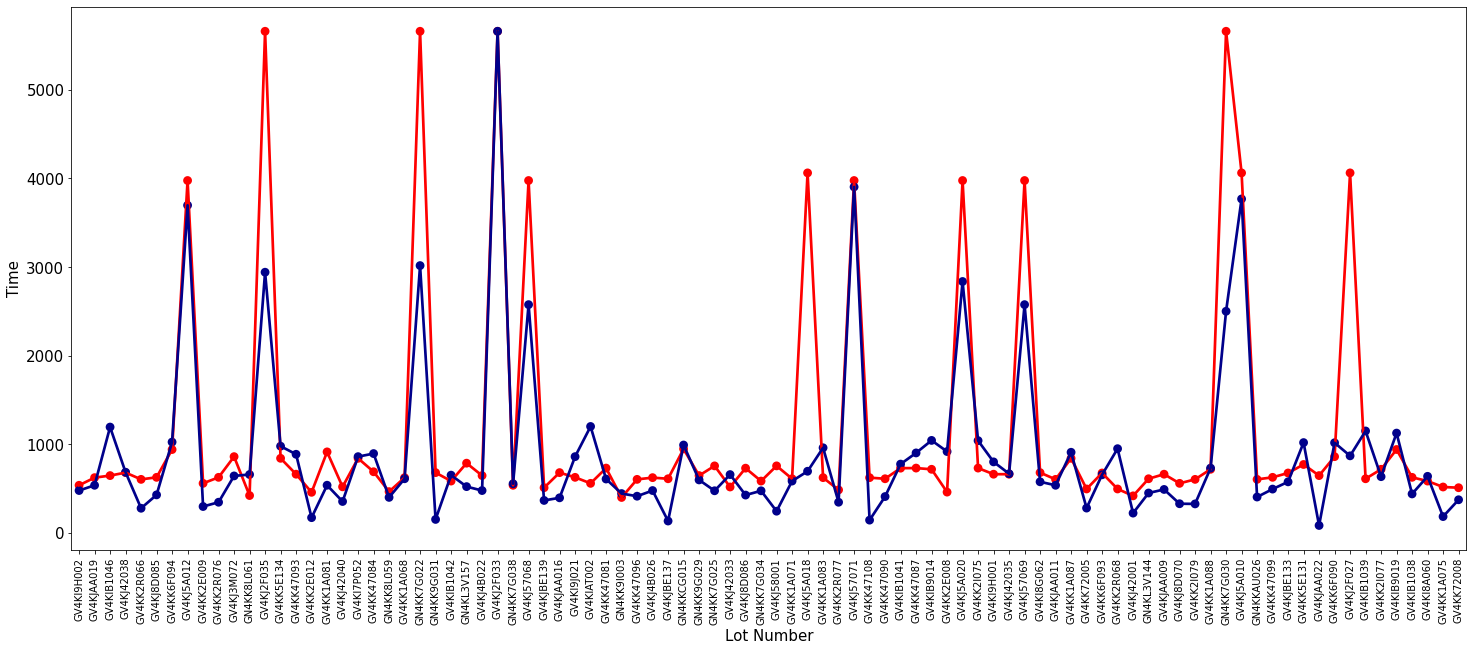

In [27]:
plt.figure(figsize=(25,10))
sns.pointplot(x='Lot No.', y='predicted_time', data=result_ae_concat, color='Red', label='y_pred')
sns.pointplot(x='Lot No.', y='y_cum_time', data=result_ae_concat, color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

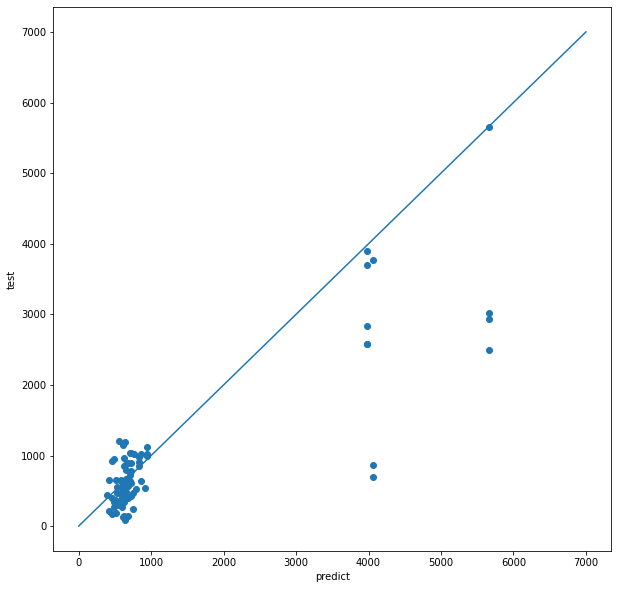

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(result_ae_concat['predicted_time'], result_ae_concat['y_cum_time'])
plt.plot([1,100,1000,7000],[1,100,1000,7000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()

In [29]:
import pkg_resources

dists = [d for d in pkg_resources.working_set]
# Filter out distributions you don't care about and use.
dists

[zipp 3.7.0 (/usr/local/lib/python3.7/dist-packages),
 zict 2.0.0 (/usr/local/lib/python3.7/dist-packages),
 yellowbrick 1.3.post1 (/usr/local/lib/python3.7/dist-packages),
 xlwt 1.3.0 (/usr/local/lib/python3.7/dist-packages),
 xlrd 1.1.0 (/usr/local/lib/python3.7/dist-packages),
 xgboost 0.90 (/usr/local/lib/python3.7/dist-packages),
 xarray 0.18.2 (/usr/local/lib/python3.7/dist-packages),
 wrapt 1.13.3 (/usr/local/lib/python3.7/dist-packages),
 wordcloud 1.5.0 (/usr/local/lib/python3.7/dist-packages),
 widgetsnbextension 3.5.2 (/usr/local/lib/python3.7/dist-packages),
 wheel 0.37.1 (/usr/local/lib/python3.7/dist-packages),
 Werkzeug 1.0.1 (/usr/local/lib/python3.7/dist-packages),
 webencodings 0.5.1 (/usr/local/lib/python3.7/dist-packages),
 wcwidth 0.2.5 (/usr/local/lib/python3.7/dist-packages),
 wasabi 0.9.0 (/usr/local/lib/python3.7/dist-packages),
 vega-datasets 0.9.0 (/usr/local/lib/python3.7/dist-packages),
 urllib3 1.24.3 (/usr/local/lib/python3.7/dist-packages),
 uritemplate 